In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from sklearn.decomposition import FastICA

In [2]:
eeg = pd.read_csv('eeg.csv')
eeg *= 10**6 # from V to uV

## Visualization of Channels

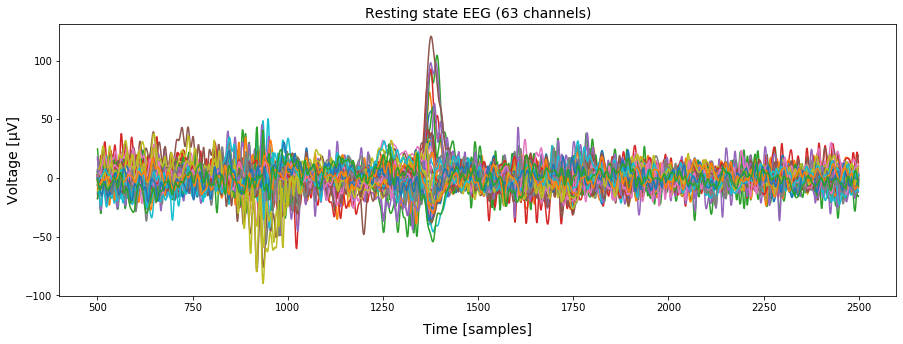

In [3]:
eeg.iloc[500:2500].plot(figsize=(15,5), legend=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=10)
plt.ylabel('Voltage [\u03BCV]', fontsize=14)
plt.title('Resting state EEG (63 channels)', fontsize=14)
#plt.savefig('eeg_all.png')
plt.show()

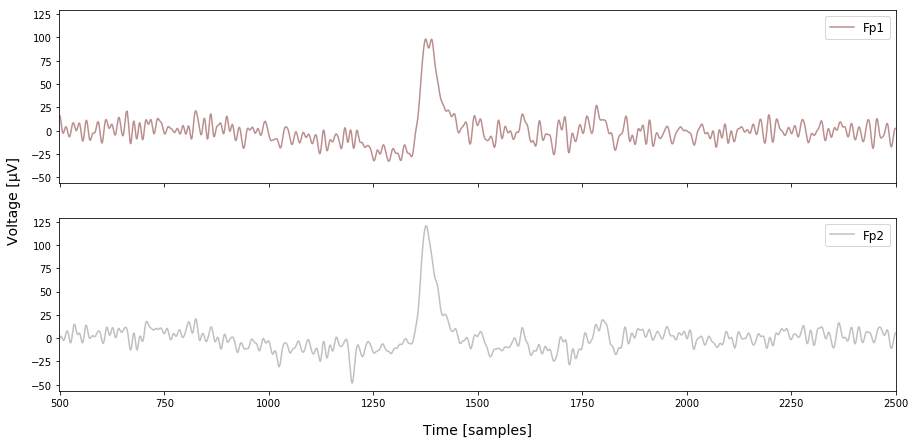

In [4]:
fig, axs = plt.subplots(2,1, figsize=(15, 7), sharex=True, sharey=True)
axs = axs.ravel()
plt.margins(x=0.001)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[0].plot(eeg['Fp1'].iloc[500:2500], label='Fp1', color='rosybrown')
axs[0].legend(loc="upper right", fontsize=12)
axs[1].plot(eeg['Fp2'].iloc[500:2500], label='Fp2', color='silver')
axs[1].legend(loc="upper right", fontsize=12)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)
plt.ylabel('Voltage [\u03BCV]', fontsize=14, labelpad=15)
#plt.savefig('fp1_fp2.png')
plt.show()

## ICA

In [5]:
ica = FastICA(n_components=63, random_state=0, tol=0.05)
comps = ica.fit_transform(eeg)

#### Visualize ICA components

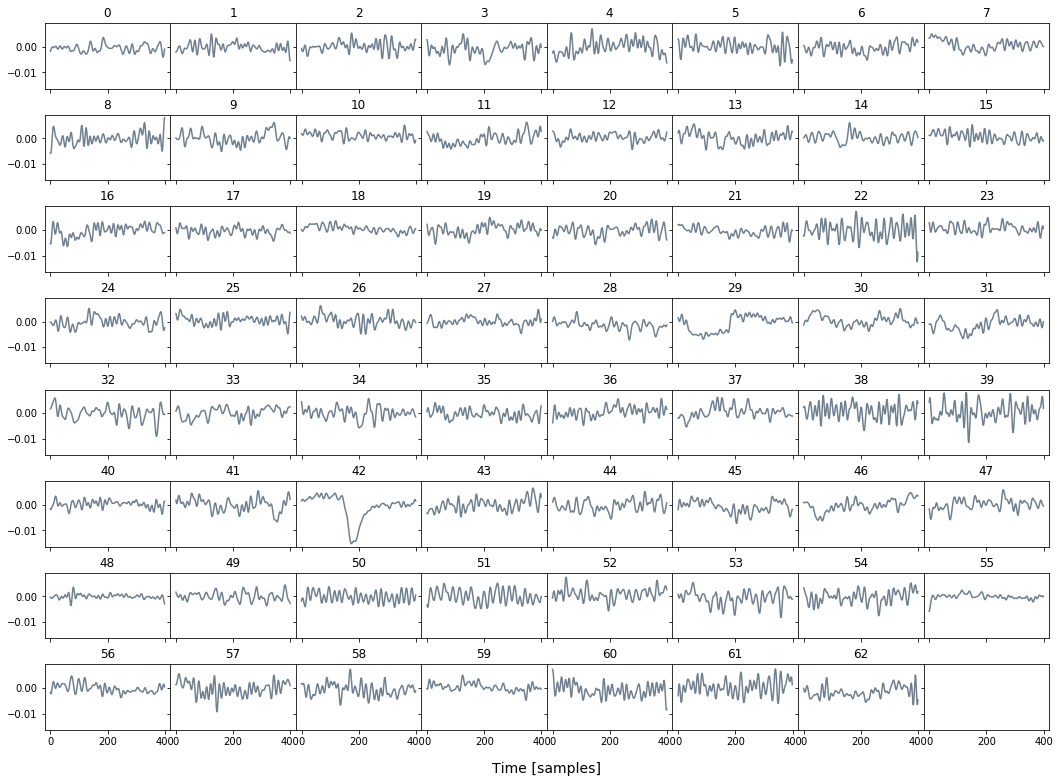

In [6]:
fig, axs = plt.subplots(8,8, figsize=(18, 13), sharex=True, sharey=True)
fig.subplots_adjust(hspace = .4, wspace=0)
axs = axs.ravel()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)

for i in range(63):
    axs[i].plot(comps[1200:1600, i], color='slategrey')
    axs[i].set_title(str(i))
    
#plt.savefig('ica_comps.png')

#### Remove components containing eye blinks / movements

In [7]:
comps_restored = comps.copy()
comps_restored[:,[29,42]] = 0 # set artefact components to zero
restored = ica.inverse_transform(comps_restored)

## Static Plot

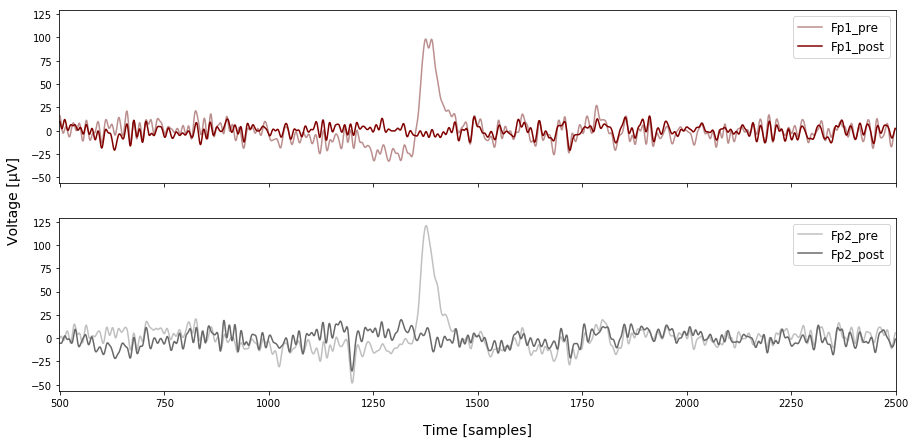

In [8]:
fig, axs = plt.subplots(2,1, figsize=(15, 7), sharex=True, sharey=True)
axs = axs.ravel()
plt.margins(x=0.001)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[0].plot(eeg['Fp1'].iloc[500:2500], label='Fp1_pre', color='rosybrown')
axs[0].plot(np.arange(500,2500), restored[500:2500, 34], label='Fp1_post', color='maroon')
axs[0].legend(loc="upper right", fontsize=12)
axs[1].plot(eeg['Fp2'].iloc[500:2500], label='Fp2_pre', color='silver')
axs[1].plot(np.arange(500,2500), restored[500:2500, 35], label='Fp2_post', color='dimgray')
axs[1].legend(loc="upper right", fontsize=12)
plt.xlabel('Time [samples]', fontsize=14, labelpad=15)
plt.ylabel('Voltage [\u03BCV]', fontsize=14, labelpad=15)
#plt.savefig('post_ica.png')
plt.show()

## Dynamic Plot

In [9]:
%matplotlib qt5
plt.ion()

sfreq = 500
visible = 2000 # time shown in plot (in samples)

sy1=deque(np.zeros(visible), visible)
sy2=deque(np.zeros(visible), visible)
sy3=deque(np.zeros(visible), visible)
sy4=deque(np.zeros(visible), visible)
sy5=deque(np.zeros(visible), visible)
sx=deque(np.zeros(visible), visible)
data_length = np.linspace(0,eeg.shape[0]+1,num=eeg.shape[0])
data_length /= sfreq

fig=plt.figure(figsize=(20,12))
ah1=fig.add_subplot(311)
ah1.set_xlabel("Time [samples]", fontsize=14, labelpad=10)
ah1.set_ylabel("Voltage [\u03BCV]", fontsize=14)
l1, = ah1.plot(sx, sy1, color='rosybrown', label='Fp1_pre')
l2, = ah1.plot(sx, sy2, color='maroon', label='Fp1_post')
ah1.legend(loc="upper right", fontsize=12, fancybox=True, framealpha=0.5)
ah2=fig.add_subplot(312)
ah2.set_xlabel("Time [samples]", fontsize=14, labelpad=10)
ah2.set_ylabel("Voltage [\u03BCV]", fontsize=14)
l3, = ah2.plot(sx, sy3, color='silver', label='Fp2_pre')
l4, = ah2.plot(sx, sy4, color='dimgray', label='Fp2_post')
ah2.legend(loc="upper right", fontsize=12, fancybox=True, framealpha=0.5)
ah3=fig.add_subplot(313)
ah3.set_xlabel("Time [s]", fontsize=14, labelpad=10)
l5, = ah3.plot(sx, sy5, color='slategrey', label='ICA Comp 42')
ah3.legend(loc="upper right", fontsize=12, fancybox=True, framealpha=0.5)


x_data=0

while x_data+visible <= 30000: 
   
    sy1.extend(eeg['Fp1'].iloc[x_data:x_data+visible])
    sy2.extend(restored[x_data:x_data+visible, 34])
    sy3.extend(eeg['Fp2'].iloc[x_data:x_data+visible])
    sy4.extend(restored[x_data:x_data+visible, 35])
    sy5.extend(comps[x_data:x_data+visible, 42])
    sx.extend(data_length[x_data:x_data+visible])

    l1.set_ydata(sy1)  
    l2.set_ydata(sy2)
    l3.set_ydata(sy3)  
    l4.set_ydata(sy4)
    l5.set_ydata(sy5)
    l1.set_xdata(sx)
    l2.set_xdata(sx)
    l3.set_xdata(sx)
    l4.set_xdata(sx)
    l5.set_xdata(sx)

    msy1=np.mean(sy1)
    msy3=np.mean(sy3)
    msy5=np.mean(sy5)

    ah1.set_ylim(-120+msy1, 200+msy1)
    ah1.set_xlim(data_length[x_data], data_length[x_data+visible])
    ah2.set_ylim(-120+msy3, 200+msy3)
    ah2.set_xlim(data_length[x_data], data_length[x_data+visible])
    ah3.set_ylim(-0.03+msy5, 0.02+msy5)
    ah3.set_xlim(data_length[x_data], data_length[x_data+visible])

    x_data += 25

    fig.canvas.draw()
    fig.canvas.flush_events()